In [107]:
import pandas as pd 
import datetime
import numpy as np
import json
from pandas.io.json import json_normalize

from nltk.corpus import stopwords

import cufflinks as cf
cf.set_config_file(offline = True)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_extraction
from sklearn.pipeline import Pipeline

import string  


# from sklearn.linear_model import LogisticRegression
# from sklearn.datasets import make_classification
# import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

In [4]:
data = [json.loads(line) for line in open('news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', 'r')]
data = json_normalize(data)
data = data.drop(['article_link'], axis=1)

In [38]:
# Count Vectorizer
countvect= CountVectorizer(binary=True, max_df=0.95, stop_words='english')
cv = countvect.fit_transform(data['headline'].values)

for i, col in enumerate(countvect.get_feature_names()):
    df = pd.SparseArray(cv[:, i].toarray().ravel(), fill_value=0)

df = pd.DataFrame(df, columns=['x'])

In [48]:
# TF-IDF Vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.95, stop_words='english')
tf = tf_vectorizer.fit_transform(data['headline'].values)

for i, col in enumerate(tf_vectorizer.get_feature_names()):
    new_df = pd.SparseArray(tf[:, i].toarray().ravel(), fill_value=0)

new_df = pd.DataFrame(new_df, columns=['y'])

In [55]:
# Creating Bag of Words
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data['headline'].values)
# X_train_counts.shape 
count_vect.vocabulary_.get(u'algorithm')

count_vect_df = pd.DataFrame.from_dict(count_vect.vocabulary_, orient='index', columns=['count_vect'])

904

In [62]:
tf_idf = TfidfVectorizer()
X_train_counts = tf_idf.fit_transform(data['headline'].values)
# X_train_counts.shape 
tf_idf.vocabulary_.get(u'algorithm')

904

In [73]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [74]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer.fit(data['headline'].values)

messages_bow = bow_transformer.transform(data['headline'].values)

CountVectorizer(analyzer=<function text_process at 0x7f79bb3afe18>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [82]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_final = tfidf_transformer.transform(messages_bow)

In [91]:
spam_detect_model = MultinomialNB().fit(tfidf_final,data['is_sarcastic'])
all_predictions = spam_detect_model.predict(tfidf_final)

print (classification_report(data['is_sarcastic'], all_predictions))

Predicted:  0
Expected:  1
[0 0 1 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     14985
           1       0.96      0.82      0.89     11724

    accuracy                           0.91     26709
   macro avg       0.92      0.90      0.90     26709
weighted avg       0.91      0.91      0.91     26709



In [95]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [96]:
x_train, x_test, y_train, y_test = train_test_split(data['headline'], data['is_sarcastic'], test_size=0.2)
print (len(x_train), len(x_test), len(y_train) + len(y_test))

21367 5342 26709


In [103]:
pipeline = Pipeline([('bow',CountVectorizer(analyzer =text_process)),
                    ('tfidf',TfidfTransformer()),
                    ('classifier',LogisticRegression())])

In [104]:
pipeline.fit(x_train,y_train)

/home/deepshikha/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7f79bb3afe18>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [105]:
predictions = pipeline.predict(x_test)

In [106]:
print (classification_report(predictions,y_test))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3335
           1       0.71      0.80      0.75      2007

    accuracy                           0.80      5342
   macro avg       0.79      0.80      0.79      5342
weighted avg       0.81      0.80      0.80      5342



In [111]:
# LogisticRegression()
clf = LogisticRegression().fit(tfidf_final,data['is_sarcastic'])
all_predictions = spam_detect_model.predict(tfidf_final)

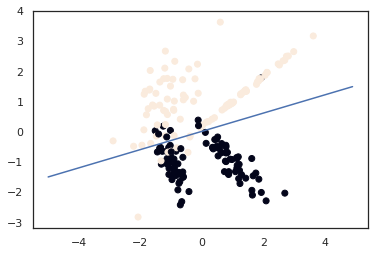

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(200, 2, 2, 0, weights=[.5, .5], random_state=15)
clf = LogisticRegression().fit(X, y)
points_x=[x/10. for x in range(-50,+50)]

line_bias = clf.intercept_
line_w = clf.coef_.T
points_y=[(line_w[0]*x+line_bias)/(-1*line_w[1]) for x in points_x]
plt.plot(points_x, points_y)

plt.scatter(X[:,0], X[:,1],c=y)

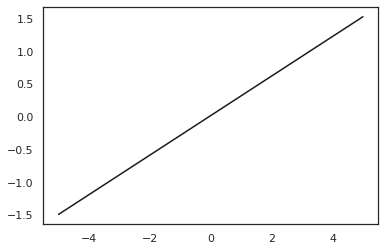

In [114]:
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

plt.plot(xx, yy, 'k-')